In [1]:
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.utils.data as Data
import torch.utils.data as torch_data
import torchvision
from torch import optim
import string
import random

In [220]:
curr_dir = os.getcwd()
rel_path = os.path.join(curr_dir, "hw7")
model_name = '\\Name_Generator7-softmax-nnloss.pt'

In [4]:
names_data = pd.read_csv(rel_path+"\\names.txt")
names_data = np.array(names_data['names'][names_data.shape[0]-2000:names_data.shape[0]]).reshape(-1,1)
names_data = [name.lower() for name in names_data[:,0]]

In [5]:
max_name_length = 0
for i in range(len(names_data)):
    max_name_length = max(max_name_length,len(names_data[i]))
max_name_length

11

In [6]:
# using the character "*" to indicate end of name (EON)
preprocess_data = np.copy(names_data)
eon = '*'
for i in range(len(names_data)):
    diff = (max_name_length - len(names_data[i]))
    append = str(eon*diff)
    preprocess_data[i] = preprocess_data[i]+append
preprocess_data

array(['brycen*****', 'oakley*****', 'isabel*****', ..., 'summer*****',
       'milena*****', 'pearl******'], dtype='<U11')

In [7]:
#one hot encoding of the alphabets

alphabet = list(string.ascii_lowercase)
alphabet.append('*')
alphabet_size = len(alphabet)
letter_num = dict()
num_letter = dict()


for i,letter in enumerate(alphabet):
    letter_num[letter] = i
    num_letter[i] = letter

numeric_data = np.array([[letter_num[lt] for lt in name] for name in preprocess_data])

def oneHotEncoding(array, num_labels):
    encoded = np.zeros((np.multiply(*array.shape),num_labels),dtype=np.float32)
    encoded[np.arange(encoded.shape[0]), array.flatten()] = 1.
    encoded = encoded.reshape((*array.shape, num_labels))
    
    return encoded

onehot_data = torch.from_numpy(oneHotEncoding(numeric_data, len(alphabet)))
onehot_data = onehot_data.view(-1, 1, max_name_length, 27)
onehot_data[0]

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0

In [8]:
outputs = np.copy(names_data)
for i in range(len(preprocess_data)):
    outputs[i] = preprocess_data[i][1:] + '*'

output_data = np.array([[letter_num[lt] for lt in name] for name in outputs])
output_oneHot = torch.from_numpy(oneHotEncoding(output_data, len(alphabet)))
output_oneHot = output_oneHot.view(-1, 1, max_name_length, 27)

In [9]:
hidden = 256
lr = 0.001
n = 2
epochs = 100
clip = 5
batch_size = 1

In [10]:
class NamesNN(nn.Module):
    
    def __init__(self, alphabet_size, hidden,n):
        super(NamesNN,self).__init__()
        self.embedding = nn.Linear(alphabet_size,alphabet_size*5)
        self.lstm = nn.LSTM(alphabet_size*5, hidden, n,batch_first=False)
        self.hiddenToAlphabet = nn.Linear(hidden,alphabet_size)
        self.hidden = hidden
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self,onehot_data,hc):
        embd = self.embedding(onehot_data)
        lstm_output, (h,c) = self.lstm(embd,hc)
        lstm_output = lstm_output.contiguous().view(lstm_output.size()[0]*lstm_output.size()[1],self.hidden)
        lstm_output = self.dropout(lstm_output)
        alphabet_sp = self.hiddenToAlphabet(lstm_output)
        alphabet_sp = F.log_softmax(alphabet_sp, dim=1)
        return alphabet_sp, (h,c)
    
    def init_hidden(self,batch_size):
        Wt = next(self.parameters()).data
        ret = Wt.new(n, max_name_length, hidden).zero_().cuda()
        return (ret,ret)

In [11]:
def loader(onehot_data,output_oneHot,batch_size):
    for i in range(onehot_data.shape[0]):
        yield onehot_data[i],output_oneHot[i]

epoch#  0
2658.724088847637
epoch#  10
2114.976481407881
epoch#  20
1432.1806806251407
epoch#  30
1062.5505344942212
epoch#  40
984.1983200330287
epoch#  50
934.9248605743051
epoch#  60
945.9705007839948
epoch#  70
968.4437523693778
epoch#  80
995.1064361776225
epoch#  90
979.3835919834673


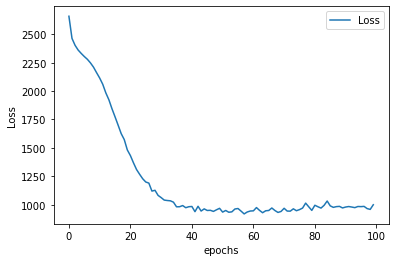

In [31]:
NNmodel = NamesNN(len(alphabet),hidden,n).cuda()
#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(NNmodel.parameters(), lr=lr)
hc = NNmodel.init_hidden(1)
# with torch.no_grad():
#     x_test = next(loader(onehot_data,output_oneHot,batch_size))[0].cuda()
#     test_scores ,(h,c) = NNmodel(x_test,hc)
#     print(test_scores.shape)
#     print(h.shape)
#     print(c.shape)

running_loss = np.zeros((epochs))

for epoch in range(epochs):
    hc = NNmodel.init_hidden(1)
    for step,(X,Y) in enumerate(loader(onehot_data,output_oneHot,batch_size)):
        NNmodel.zero_grad()
        hc = tuple([each.data for each in hc])
        X = X.cuda()
        y_pred,hc = NNmodel(X,hc)
        
        Y_actual = torch.max(Y,2)[1].flatten().cuda()
        loss = criterion(y_pred,Y_actual)
        running_loss[epoch] += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(NNmodel.parameters(), clip)
        optimizer.step()
        
    if epoch%10 == 0:
        print("epoch# ", epoch)
        print(running_loss[epoch])

plt.plot(running_loss, label='Loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

In [213]:
torch.save(NNmodel.state_dict(), rel_path + model_name)
torch.save(NNmodel,'0702-659703805-Thakur.pth')